In [82]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from metrics import * 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve

In [83]:
df = pd.read_parquet("xgboost_dataset_ebnerd_small.parquet")
print(len(df))

df

1882518


,session_id,user_id,article_id,clicked,sentiment_score,is_premium_user,readtime_avg
0,4180,526520,9743870,False,0.9466,False,0.0
1,4180,526520,9776386,False,0.9678,False,0.0
2,4180,526520,9776394,False,0.9386,False,0.0
3,4180,526520,9776438,False,0.8330,False,0.0
4,4180,526520,9776442,True,0.9086,False,0.0
...,...,...,...,...,...,...,...
1882513,747086,2110744,9771042,True,0.6719,False,0.0
1882514,747086,2110744,9514481,False,0.9501,False,0.0
1882515,747086,2110744,9440508,False,0.9076,False,0.0
1882516,747086,2110744,9142581,False,0.6342,False,0.0


In [84]:
def split_by_session(data, test_size=0.2, random_state=42):
    # Get unique sessions
    unique_sessions = data['session_id'].unique()
    
    # Split sessions into train and test
    train_sessions, test_sessions = train_test_split(unique_sessions, 
                                                    test_size=test_size, 
                                                    random_state=random_state)
    
    # Create train and test sets
    train_data = data[data['session_id'].isin(train_sessions)]
    test_data = data[data['session_id'].isin(test_sessions)]
    
    return train_data, test_data

In [85]:
train_data, test_data = split_by_session(df, test_size = 0.2)


In [86]:
"""
# Assertion for training data
for session in train_data['session_id'].unique():
    clicked_values = train_data[train_data['session_id'] == session]['clicked'].unique()
    assert set(clicked_values) == {True, False}, f"Session {session} in train data does not contain both True and False."

# Assertion for testing data
for session in test_data['session_id'].unique():
    clicked_values = test_data[test_data['session_id'] == session]['clicked'].unique()
    assert set(clicked_values) == {True, False}, f"Session {session} in test data does not contain both True and False."

print("All assertions passed. Each session in both train and test data contains both True and False in 'clicked'.")
"""

All assertions passed. Each session in both train and test data contains both True and False in 'clicked'.


In [87]:
train_data.head()

,session_id,user_id,article_id,clicked,sentiment_score,is_premium_user,readtime_avg
0,4180,526520,9743870,False,0.9466,False,0.0
1,4180,526520,9776386,False,0.9678,False,0.0
2,4180,526520,9776394,False,0.9386,False,0.0
3,4180,526520,9776438,False,0.8330,False,0.0
4,4180,526520,9776442,True,0.9086,False,0.0


In [88]:


# Features and labels for training
feature_list = ["sentiment_score","is_premium_user", "readtime_avg"]
X_train = train_data[feature_list].values
y_train = train_data['clicked'].values

X_test = test_data[feature_list].values
y_test = test_data['clicked'].values

# Group (number of articles per session)
group_train = train_data.groupby('session_id').size().to_list()
group_test = test_data.groupby('session_id').size().to_list()


In [89]:
# Convert training data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(group_train)

# Convert test data to DMatrix
dtest = xgb.DMatrix(X_test)
dtest.set_group(group_test)


# Set parameters for XGBoost ranking
params = {
    'objective': 'rank:pairwise',  # Pairwise ranking objective
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Max tree depth
    'eval_metric': 'ndcg'  # Evaluation metric: Normalized Discounted Cumulative Gain
}

# Train the XGBoost model
bst = xgb.train(params, dtrain, num_boost_round=500)


In [90]:
# Make predictions on the test set
y_pred = bst.predict(dtest)

# Add predictions to the test dataframe
test_data['predicted_score'] = y_pred


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_46775/625873487.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_score'] = y_pred


In [91]:
# Sort articles by predicted score within each session
test_data = test_data.sort_values(by=['session_id', 'predicted_score'], ascending=[True, False])

# Display the ranked articles
print(test_data[['session_id', 'article_id', 'predicted_score']])




         session_id  article_id  predicted_score
959788          421     9773877         0.883183
959783          421     9773900         0.240434
959784          421     9773279         0.005759
959786          421     9773943        -0.019199
959785          421     9773962        -0.026310
...             ...         ...              ...
1832763     2027548     9345280        -0.197374
1832759     2027548     9767903        -0.277649
1832766     2027548     9459174        -0.291120
1832757     2027548     9771352        -0.317650
1832760     2027548     9440508        -0.457818

[379852 rows x 3 columns]


In [92]:

results = test_data.groupby('session_id', group_keys=False).apply(lambda x: pd.Series({
    'AUC': calculate_auc(x),
    'MRR': calculate_mrr(x),
    'NDCG@5': calculate_ndcg(x, 5),
    'NDCG@10': calculate_ndcg(x, 10)
}))

print(results)


                 AUC       MRR    NDCG@5   NDCG@10
session_id                                        
421         1.000000  1.000000  1.000000  1.000000
427         1.000000  1.000000  1.000000  1.000000
447         0.500000  0.333333  0.500000  0.500000
757         0.541667  0.111111  0.000000  0.141267
797         1.000000  1.000000  1.000000  1.000000
...              ...       ...       ...       ...
2023772     0.891304  1.000000  0.613147  0.817530
2025015     0.666667  0.333333  0.500000  0.500000
2025896     1.000000  1.000000  1.000000  1.000000
2025931     0.561404  0.200000  0.181542  0.181542
2027548     0.785714  1.000000  0.613147  0.806574

[17487 rows x 4 columns]


/var/folders/81/jf2m8tyj02q6bhybvrfzfw_c0000gn/T/ipykernel_46775/2882871820.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = test_data.groupby('session_id', group_keys=False).apply(lambda x: pd.Series({


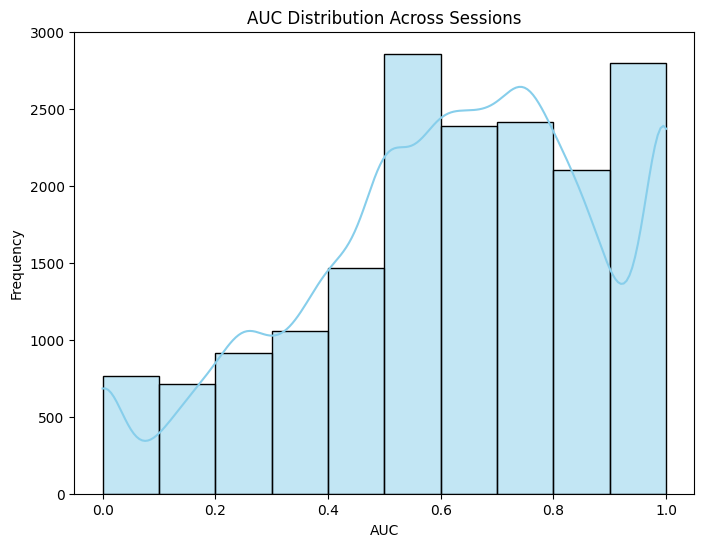

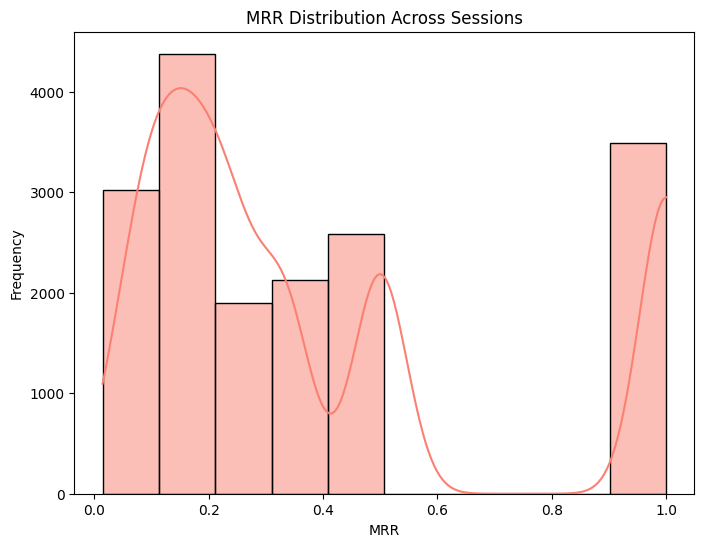

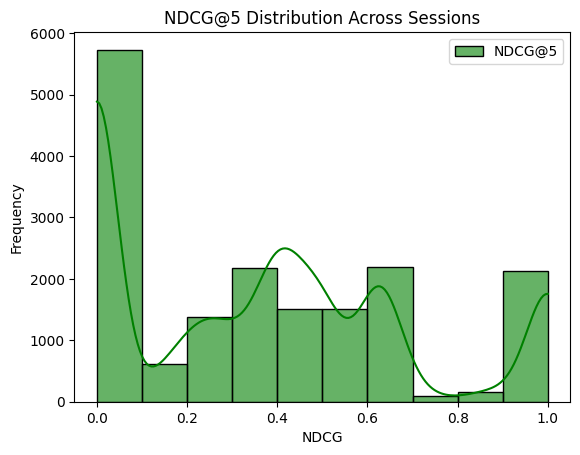

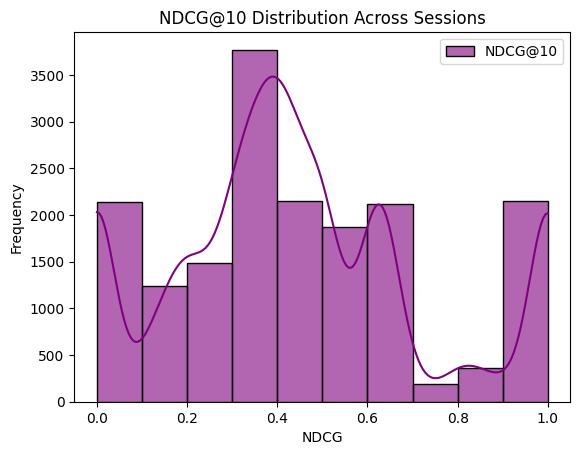

In [93]:
# Plot 1: Precision-Recall Curve for a sample session
def plot_precision_recall(data):
    precision, recall, _ = precision_recall_curve(data['clicked'], data['predicted_score'])
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

# Plot 2: AUC Distribution Across Sessions
plt.figure(figsize=(8, 6))
sns.histplot(results['AUC'], kde=True, color="skyblue", bins=10)
plt.title("AUC Distribution Across Sessions")
plt.xlabel("AUC")
plt.ylabel("Frequency")
plt.show()

# Plot 3: MRR Distribution
plt.figure(figsize=(8, 6))
sns.histplot(results['MRR'], kde=True, color="salmon", bins=10)
plt.title("MRR Distribution Across Sessions")
plt.xlabel("MRR")
plt.ylabel("Frequency")
plt.show()

# Plot 4: NDCG@5 and NDCG@10 Distributions
sns.histplot(results['NDCG@5'], kde=True, color="green", label="NDCG@5", bins=10, alpha=0.6)
plt.title("NDCG@5 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()


sns.histplot(results['NDCG@10'], kde=True, color="purple", label="NDCG@10", bins=10, alpha=0.6)
plt.title("NDCG@10 Distribution Across Sessions")
plt.xlabel("NDCG")
plt.ylabel("Frequency")
plt.legend()
plt.show()
